In [1]:
!pip3 install PyYAML==5.1
!pip install mido==1.2.9

     |████████████████████████████████| 274 kB 5.2 MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=ba16a95413b449793fd31cc670484f53d683bfd59cf4c0c37d0e11cb1327f54f
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built PyYAML
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 52 kB 1.0 MB/s 


In [2]:
!git clone https://github.com/YatingMusic/MuseMorphose.git

Cloning into 'MuseMorphose'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 78 (delta 29), reused 48 (delta 12), pack-reused 0
Unpacking objects: 100% (78/78), done.


In [3]:
%cd MuseMorphose/

/content/MuseMorphose


In [4]:
!pip3 install -r requirements.txt

In [5]:
!wget -O remi_dataset.tar.gz https://zenodo.org/record/4782721/files/remi_dataset.tar.gz?download=1
!tar xzvf remi_dataset.tar.gz
!rm remi_dataset.tar.gz

--2021-11-07 18:21:26--  https://zenodo.org/record/4782721/files/remi_dataset.tar.gz?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60167785 (57M) [application/octet-stream]
Saving to: ‘remi_dataset.tar.gz’

remi_dataset.tar.gz 100%[===================>]  57.38M  15.7MB/s    in 3.6s    

2021-11-07 18:21:31 (15.7 MB/s) - ‘remi_dataset.tar.gz’ saved [60167785/60167785]

remi_dataset/
remi_dataset/1000.pkl
remi_dataset/1001.pkl
remi_dataset/1002.pkl
remi_dataset/1003.pkl
remi_dataset/1004.pkl
remi_dataset/1005.pkl
remi_dataset/1006.pkl
remi_dataset/1007.pkl
remi_dataset/1008.pkl
remi_dataset/1009.pkl
remi_dataset/100.pkl
remi_dataset/1010.pkl
remi_dataset/1011.pkl
remi_dataset/1012.pkl
remi_dataset/1013.pkl
remi_dataset/1014.pkl
remi_dataset/1015.pkl
remi_dataset/1016.pkl
remi_dataset/1017.pkl
remi_dataset/1018.pkl
remi_dataset/1019.pkl
remi_dataset

**Explore the dataset**

In [6]:
!python3 attributes.py

[rhythm classes] Counter({5: 35456, 1: 29944, 4: 22344, 3: 22298, 0: 21198, 2: 21001, 6: 15834, 7: 15250})
[polyph classes] Counter({2: 27521, 0: 24821, 5: 23600, 6: 22306, 3: 22247, 7: 22170, 4: 21745, 1: 18915})


In [7]:
!mkdir midi_files

In [8]:
from midi_converter import check
from midifile import MidiFile

ModuleNotFoundError: ignored

In [8]:
'''
import pickle
import numpy as np
from remi2midi import remi2midi
from dataloader import REMIFullSongTransformerDataset
from utils import pickle_load
import random
import sys
import os
import yaml
sys.path.append('./model')

with open('remi_dataset/836.pkl', 'rb') as f:
    piece = pickle.load(f)

def word2event(word_seq, idx2event):
  return [ idx2event[w] for w in word_seq ]

config_path = './config/default.yaml'
config = yaml.load(open(config_path, 'r'), Loader=yaml.FullLoader)
data_split = 'pickles/test_pieces.pkl'

data_dir = config['data']['data_dir']
vocab_path = config['data']['vocab_path']

dset = REMIFullSongTransformerDataset(
    data_dir, vocab_path, 
    do_augment=False,
    model_enc_seqlen=config['data']['enc_seqlen'], 
    model_dec_seqlen=config['generate']['dec_seqlen'],
    model_max_bars=config['generate']['max_bars'],
    pieces=pickle_load(data_split),
    pad_to_same=False
  )

pieces = random.sample(range(len(dset)), 1)
for p in pieces:
  p_data = dset[p]
  p_id = p_data['piece_id']
  p_bar_id = p_data['st_bar_id']
  p_data['enc_input'] = p_data['enc_input'][ : p_data['enc_n_bars'] ]
  p_data['enc_padding_mask'] = p_data['enc_padding_mask'][ : p_data['enc_n_bars'] ]
  orig_song = p_data['dec_input'].tolist()[:p_data['length']]
  orig_song = word2event(orig_song, dset.idx2event)
  
  midi_obj, orig_tempo = remi2midi(orig_song, 'midi_files.mid', return_first_tempo=True, enforce_tempo=False)

'''

[preparing data] now at #0
midi_files.mid


In [9]:
'''
import mido
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import colorConverter


# inherit the origin mido class
class MidiFile(mido.MidiFile):

    def __init__(self, filename):

        mido.MidiFile.__init__(self, filename)
        self.sr = 10
        self.meta = {}
        self.events = self.get_events()

    def get_events(self):
        mid = self
        print(mid)

        # There is > 16 channel in midi.tracks. However there is only 16 channel related to "music" events.
        # We store music events of 16 channel in the list "events" with form [[ch1],[ch2]....[ch16]]
        # Lyrics and meta data used a extra channel which is not include in "events"

        events = [[] for x in range(16)]

        # Iterate all event in the midi and extract to 16 channel form
        for track in mid.tracks:
            for msg in track:
                try:
                    channel = msg.channel
                    events[channel].append(msg)
                except AttributeError:
                    try:
                        if type(msg) != type(mido.UnknownMetaMessage):
                            self.meta[msg.type] = msg.dict()
                        else:
                            pass
                    except:
                        print("error",type(msg))

        return events

    def get_roll(self):
        events = self.get_events()
        # Identify events, then translate to piano roll
        # choose a sample ratio(sr) to down-sample through time axis
        sr = self.sr

        # compute total length in tick unit
        length = self.get_total_ticks()

        # allocate memory to numpy array
        roll = np.zeros((16, 128, length // sr), dtype="int8")

        # use a register array to save the state(no/off) for each key
        note_register = [int(-1) for x in range(128)]

        # use a register array to save the state(program_change) for each channel
        timbre_register = [1 for x in range(16)]


        for idx, channel in enumerate(events):

            time_counter = 0
            volume = 100
            # Volume would change by control change event (cc) cc7 & cc11
            # Volume 0-100 is mapped to 0-127

            print("channel", idx, "start")
            for msg in channel:
                if msg.type == "control_change":
                    if msg.control == 7:
                        volume = msg.value
                        # directly assign volume
                    if msg.control == 11:
                        volume = volume * msg.value // 127
                        # change volume by percentage
                    # print("cc", msg.control, msg.value, "duration", msg.time)

                if msg.type == "program_change":
                    timbre_register[idx] = msg.program
                    print("channel", idx, "pc", msg.program, "time", time_counter, "duration", msg.time)



                if msg.type == "note_on":
                    print("on ", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_on_start_time = time_counter // sr
                    note_on_end_time = (time_counter + msg.time) // sr
                    intensity = volume * msg.velocity // 127



					# When a note_on event *ends* the note start to be play 
					# Record end time of note_on event if there is no value in register
					# When note_off event happens, we fill in the color
                    if note_register[msg.note] == -1:
                        note_register[msg.note] = (note_on_end_time,intensity)
                    else:
					# When note_on event happens again, we also fill in the color
                        old_end_time = note_register[msg.note][0]
                        old_intensity = note_register[msg.note][1]
                        roll[idx, msg.note, old_end_time: note_on_end_time] = old_intensity
                        note_register[msg.note] = (note_on_end_time,intensity)


                if msg.type == "note_off":
                    print("off", msg.note, "time", time_counter, "duration", msg.time, "velocity", msg.velocity)
                    note_off_start_time = time_counter // sr
                    note_off_end_time = (time_counter + msg.time) // sr
                    note_on_end_time = note_register[msg.note][0]
                    intensity = note_register[msg.note][1]
					# fill in color
                    roll[idx, msg.note, note_on_end_time:note_off_end_time] = intensity

                    note_register[msg.note] = -1  # reinitialize register

                time_counter += msg.time

                # TODO : velocity -> done, but not verified
                # TODO: Pitch wheel
                # TODO: Channel - > Program Changed / Timbre catagory
                # TODO: real time scale of roll

            # if there is a note not closed at the end of a channel, close it
            for key, data in enumerate(note_register):
                if data != -1:
                    note_on_end_time = data[0]
                    intensity = data[1]
                    # print(key, note_on_end_time)
                    note_off_start_time = time_counter // sr
                    roll[idx, key, note_on_end_time:] = intensity
                note_register[idx] = -1

        return roll

    def get_roll_image(self):
        roll = self.get_roll()
        plt.ioff()

        K = 16

        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / K, 1, 1)), alpha=1) for i in range(K)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(K)]

        for i in range(K):
            cmaps[i]._init()  # create the _lut array, with rgba values
            # create your alpha array and fill the colormap with them.
            # here it is progressive, but you can create whathever you want
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            cmaps[i]._lut[:, -1] = alphas

        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        array = []

        for i in range(K):
            try:
                img = a1.imshow(roll[i], interpolation='nearest', cmap=cmaps[i], aspect='auto')
                array.append(img.get_array())
            except IndexError:
                pass
        return array

    def draw_roll(self):


        roll = self.get_roll()

        # build and set fig obj
        plt.ioff()
        fig = plt.figure(figsize=(4, 3))
        a1 = fig.add_subplot(111)
        a1.axis("equal")
        a1.set_facecolor("black")

        # change unit of time axis from tick to second
        tick = self.get_total_ticks()
        second = mido.tick2second(tick, self.ticks_per_beat, self.get_tempo())
        print(second)
        if second > 10:
            x_label_period_sec = second // 10
        else:
            x_label_period_sec = second / 10  # ms
        print(x_label_period_sec)
        x_label_interval = mido.second2tick(x_label_period_sec, self.ticks_per_beat, self.get_tempo()) / self.sr
        print(x_label_interval)
        plt.xticks([int(x * x_label_interval) for x in range(20)], [round(x * x_label_period_sec, 2) for x in range(20)])

        # change scale and label of y axis
        plt.yticks([y*16 for y in range(8)], [y*16 for y in range(8)])

        # build colors
        channel_nb = 16
        transparent = colorConverter.to_rgba('black')
        colors = [mpl.colors.to_rgba(mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)), alpha=1) for i in range(channel_nb)]
        cmaps = [mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [transparent, colors[i]], 128) for i in
                 range(channel_nb)]

        # build color maps
        for i in range(channel_nb):
            cmaps[i]._init()
            # create your alpha array and fill the colormap with them.
            alphas = np.linspace(0, 1, cmaps[i].N + 3)
            # create the _lut array, with rgba values
            cmaps[i]._lut[:, -1] = alphas


        # draw piano roll and stack image on a1
        for i in range(channel_nb):
            try:
                a1.imshow(roll[i], origin="lower", interpolation='nearest', cmap=cmaps[i], aspect='auto')
            except IndexError:
                pass

        # draw color bar

        colors = [mpl.colors.hsv_to_rgb((i / channel_nb, 1, 1)) for i in range(channel_nb)]
        mpl.rcParams["figure.figsize"] = [50, 50]
        cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', colors, 16)
        a2 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
        cbar = mpl.colorbar.ColorbarBase(a2, cmap=cmap,
                                        orientation='horizontal',
                                        ticks=list(range(16)))

        # show piano roll
        plt.draw()
        plt.ion()
        plt.show(block=True)

    def get_tempo(self):
        try:
            return self.meta["set_tempo"]["tempo"]
        except:
            return 500000

    def get_total_ticks(self):
        max_ticks = 0
        for channel in range(16):
            ticks = sum(msg.time for msg in self.events[channel])
            if ticks > max_ticks:
                max_ticks = ticks
        return max_ticks
'''

<midi file 'midi_files.mid' type 1, 2 tracks, 404 messages>
<midi file 'midi_files.mid' type 1, 2 tracks, 404 messages>
channel 0 start
channel 0 pc 0 time 0 duration 0
on  43 time 0 duration 0 velocity 64
on  64 time 0 duration 0 velocity 64
on  43 time 0 duration 240 velocity 0
on  50 time 240 duration 0 velocity 58
on  55 time 240 duration 240 velocity 66
on  67 time 480 duration 0 velocity 66
on  64 time 480 duration 120 velocity 0
on  50 time 600 duration 120 velocity 0
on  55 time 720 duration 0 velocity 0
on  57 time 720 duration 0 velocity 62
on  43 time 720 duration 240 velocity 46
on  59 time 960 duration 0 velocity 66
on  43 time 960 duration 240 velocity 0
on  43 time 1200 duration 0 velocity 46
on  57 time 1200 duration 0 velocity 0
on  62 time 1200 duration 0 velocity 64
on  59 time 1200 duration 480 velocity 0
on  59 time 1680 duration 0 velocity 52
on  43 time 1680 duration 120 velocity 0
on  40 time 1800 duration 120 velocity 46
on  59 time 1920 duration 0 velocity 0
o

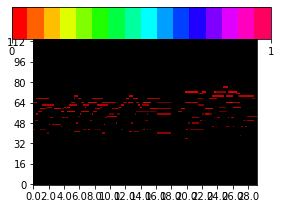

In [10]:
mid = MidiFile('midi_files.mid')
roll = mid.get_roll()
mid.draw_roll()

In [11]:
!wget -O musemorphose_pretrained_weights.pt https://zenodo.org/record/5119525/files/musemorphose_pretrained_weights.pt?download=1

--2021-11-07 17:23:02--  https://zenodo.org/record/5119525/files/musemorphose_pretrained_weights.pt?download=1
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 359717524 (343M) [application/octet-stream]
Saving to: ‘musemorphose_pretrained_weights.pt’

musemorphose_pretra 100%[===================>] 343.05M  24.3MB/s    in 16s     

2021-11-07 17:23:19 (22.1 MB/s) - ‘musemorphose_pretrained_weights.pt’ saved [359717524/359717524]



In [12]:
!python3 generate.py config/default.yaml musemorphose_pretrained_weights.pt generations/ 1 1

[preparing data] now at #0
[sampled pieces] [7]
[info] writing to ... generations/id7_bar51_orig
generations/id7_bar51_orig.mid
[info] piece: 1174, bar: 51
[info] writing to ... generations/id7_bar51_sample01_poly-1_rhym+3
[info] rhythm cls: tensor([3, 4, 4, 3, 5, 4, 4, 3, 5, 3, 7, 6, 6, 7, 7, 6], device='cuda:0') | polyph_cls: tensor([1, 1, 1, 1, 1, 3, 1, 1, 2, 1, 0, 2, 0, 0, 0, 0], device='cuda:0')
[info] generated 1 bars, #events = 40
[info] generated 2 bars, #events = 87
[info] generated 3 bars, #events = 136
[info] generated 4 bars, #events = 169
[info] generated 5 bars, #events = 211
[info] generated 6 bars, #events = 252
[info] generated 7 bars, #events = 301
[info] generated 8 bars, #events = 341
[info] generated 9 bars, #events = 391
[info] generated 10 bars, #events = 427
[info] generated 11 bars, #events = 475
[info] generated 12 bars, #events = 529
[info] generated 13 bars, #events = 577
[info] generated 14 bars, #events = 638
[info] generated 15 bars, #events = 698
[info] 

In [13]:
import yaml
yaml.__version__

'5.1'